In [1]:
library("survival")
library("survminer")
library("ranger")
library("ggplot2")
library("dplyr")
library("ggfortify")
library("randomForestSRC")
library("ggRandomForests")

Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: ggpubr
Loading required package: magrittr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


 randomForestSRC 2.9.3 
 
 Type rfsrc.news() to see new features, changes, and bug fixes. 
 


Attaching package: ‘ggRandomForests’

The following object is masked from ‘package:randomForestSRC’:

    partial.rfsrc



In [2]:
df <- read.csv("Final_NHANES_2013_2014.csv")

In [4]:
colnames(df)

[1] "Gender"          "Age"             "Poverty"         "Weight"         
 [5] "Height"          "BMI"             "Pulse"           "BPSysAve"       
 [9] "BPDiaAve"        "DirectChol"      "TotChol"         "FatFoods"       
[13] "UrineVol1"       "UrineFlow1"      "Diabetes"        "HealthGen"      
[17] "SleepHrsNight"   "SleepTrouble"    "PhysActive"      "WalkBic"        
[21] "VigActiv"        "ModActiv"        "TVHrsDay"        "AlcoholDay"     
[25] "AlcoholYear"     "Smoke100"        "GlycoHemoglobin" "mortstat"

In [5]:
#Selecting only variables used in our model
df = select(df,Age, Weight,BMI,Pulse, TotChol, Diabetes ,SleepHrsNight, Smoke100, PhysActive, WalkBic, VigActiv, ModActiv, TVHrsDay, FatFoods, AlcoholDay, AlcoholYear, mortstat)

In [6]:
dim(df)

[1] 10175    17

In [7]:
#Change mortstat variable so that it's appropriate for survival analysis
#It was defined in the opposite way for the classification
for(i in 1:10175){
    if(df$mortstat[i] == 1) df$mortstat[i] = 0
    else df$mortstat[i] = 1
}

In [8]:
#Checking that there is no factor
sapply(df, class)

Age        Weight           BMI         Pulse       TotChol 
    "numeric"     "numeric"     "numeric"     "numeric"     "numeric" 
     Diabetes SleepHrsNight      Smoke100    PhysActive       WalkBic 
    "integer"     "numeric"     "integer"     "integer"     "integer" 
     VigActiv      ModActiv      TVHrsDay      FatFoods    AlcoholDay 
    "integer"     "integer"     "numeric"     "numeric"     "numeric" 
  AlcoholYear      mortstat 
    "numeric"     "numeric"

In [9]:
head(df)

Age,Weight,BMI,Pulse,TotChol,Diabetes,SleepHrsNight,Smoke100,PhysActive,WalkBic,VigActiv,ModActiv,TVHrsDay,FatFoods,AlcoholDay,AlcoholYear,mortstat
69,"78,3","26,7",86,"4,32",1,7,1,0,0,0,0,2,8,1,1,0
54,"89,5","28,6",74,"4,40",1,9,1,1,0,0,0,4,0,4,7,0
72,"88,9","28,9",68,"3,26",1,8,1,1,0,0,1,4,1,2,0,0
9,"32,2","17,1",64,"4,34",0,7,0,0,0,0,0,3,0,2,2,1
73,"52,0","19,7",92,"5,20",0,9,0,1,0,0,0,1,0,2,0,1
56,"105,0","41,7",60,"5,84",0,5,1,0,0,0,0,5,14,1,5,0


In [10]:
# Create the trial and test data sets.
# Random sample indexes
train_index <- sample(1:nrow(df), 0.8 * nrow(df))
test_index <- setdiff(1:nrow(df), train_index)

# Build X_train, y_train, X_test, y_test
df_train <- df[train_index,]
df_test <- df[test_index,]

In [11]:
#Checking that there is no missing values
sum(is.na(df))

[1] 0

In [12]:
sum(is.nan(as.matrix(df)))

[1] 0

In [13]:
#Object for KM curves
gg_dta <- gg_survival(interval = "Age", censor = "mortstat",data=df_train, by = "Smoke100", conf.int = 0.95)

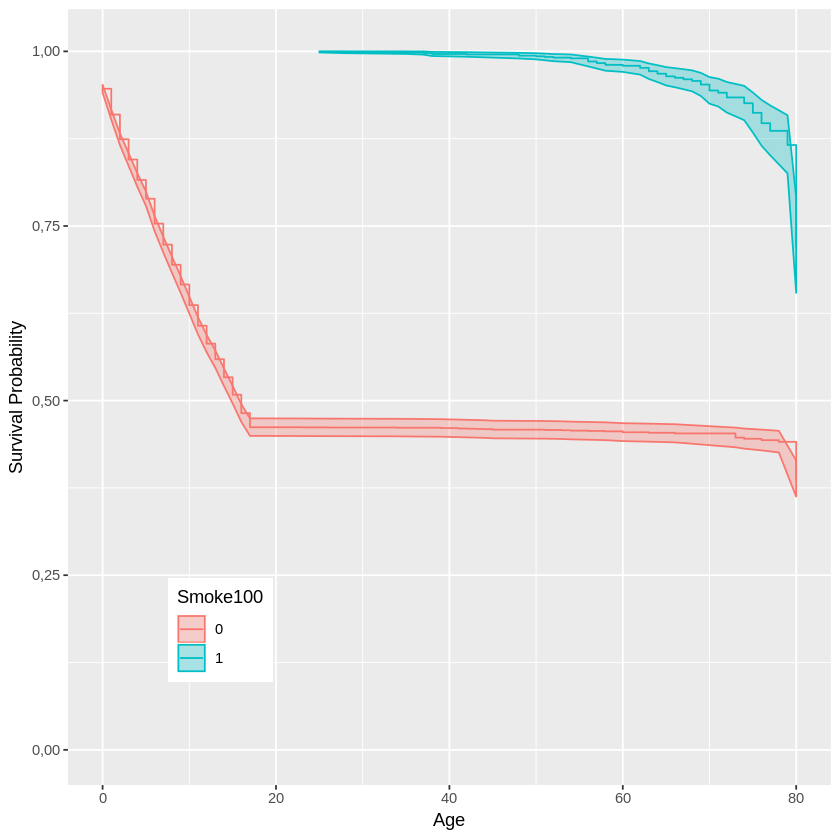

In [14]:
#plotting KM curve segregating by smokers
plot(gg_dta) +
labs(y = "Survival Probability", x = "Age",
color = "Smoke100", fill = "Smoke100") +
theme(legend.position = c(0.2, 0.2)) +
coord_cartesian(y = c(0, 1.01))

In [15]:
gg_dta <- gg_survival(interval = "Age", censor = "mortstat",data=df_train, by = "PhysActive", conf.int = 0.95)

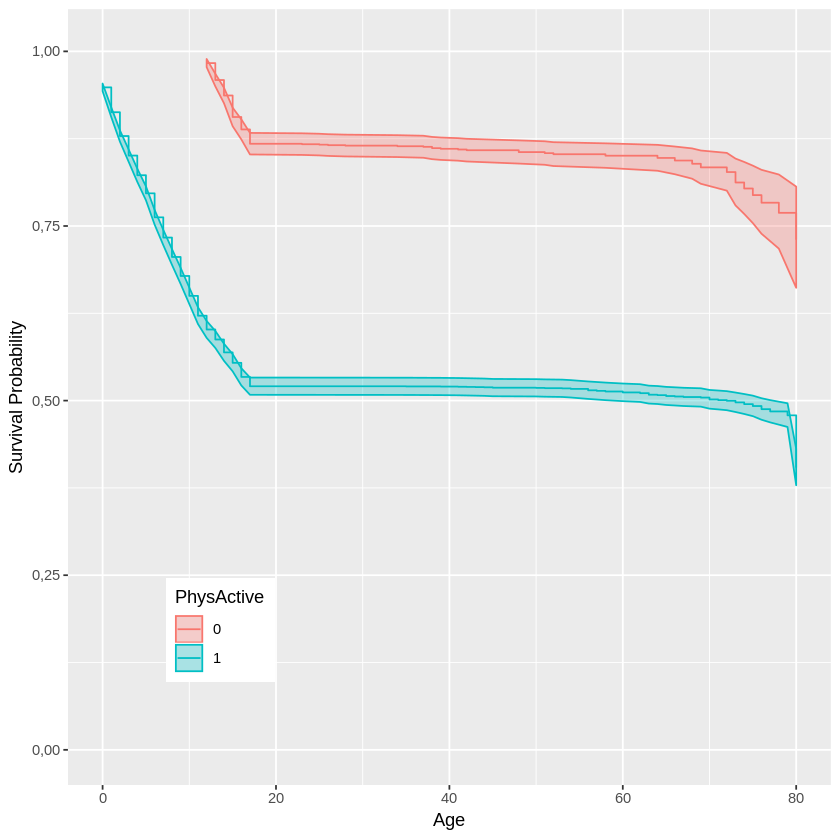

In [16]:
#Plotting KM curves segregating by physical activity
plot(gg_dta) +
labs(y = "Survival Probability", x = "Age",
color = "PhysActive", fill = "PhysActive") +
theme(legend.position = c(0.2, 0.2)) +
coord_cartesian(y = c(0, 1.01))

In [64]:
#Breaking a selected variable in ranges
#If the variable is between [min, max], then we will break it into
#[min, x1], [x1,x2], [x2,x3],...,[x_quant,max]
#The idea is to search the range that gives better survival curve
#Like that we can suggest these ranges for people
get_ranges <- function(col, quant){
    min_value = min(col)
    max_value = max(col)
    ranges <- min_value
    eps <- (max_value - min_value)/quant
    crawl <- min_value + eps
    while(crawl < max_value){
        ranges <- c(ranges, crawl)
        crawl <- crawl + eps 
    }
    ranges <- c(ranges, max_value)
    return(ranges)
}

In [81]:
get_ranges(df_train$TotChol, 4)

[1]  1,9700  6,7325 11,4950 16,2575 21,0200

In [82]:
df_chol <- df_train
df_chol$TotChol <- cut(df_chol$TotChol, breaks = get_ranges(df_chol$TotChol, 5))

Warning message in log(hzrd):
“NaNs produzidos”

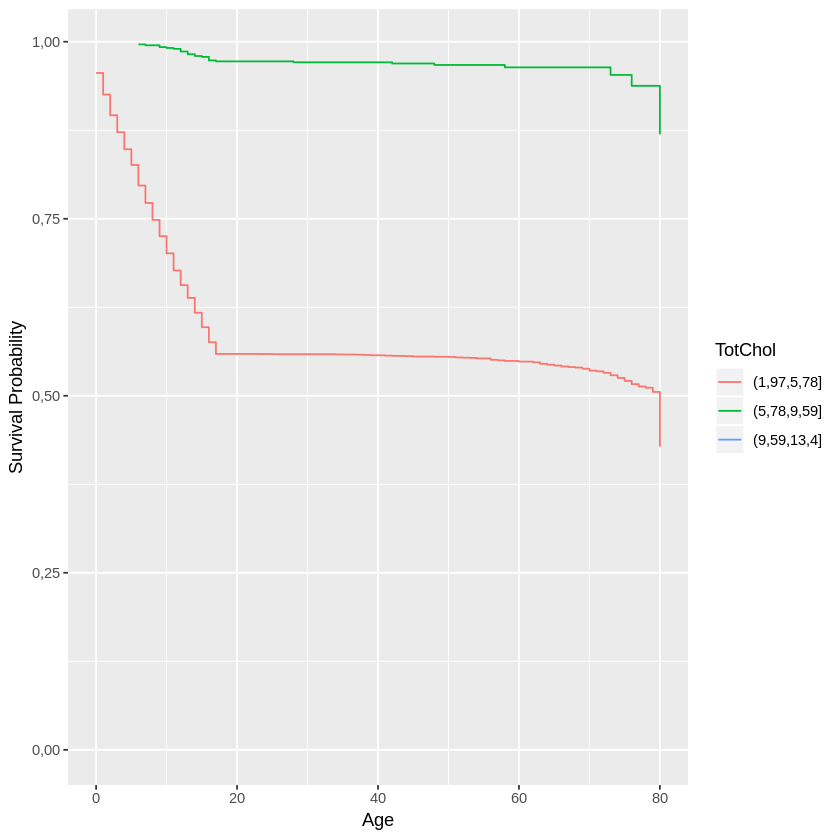

In [83]:
plot(gg_survival(interval = "Age", censor = "mortstat", by = "TotChol",
data = df_chol), error = "none") +
labs(y = "Survival Probability", x = "Age",
color = "TotChol")

In [84]:
chol_surv <- gg_survival(interval = "Age", censor = "mortstat", by = "TotChol",
data = df_chol)

Warning message in log(hzrd):
“NaNs produzidos”

In [85]:
chol_surv

,time,n,cens,dead,surv,se,lower,upper,cum_haz,groups,hazard,density,mid_int,life,proplife
1,0,7342,0,324,"0,9558703","0,002507602","0,9511839","0,9605798","0,04513301","(1,97,5,78]",Inf,Inf,"0,0","0,0000000",NaN
2,1,7018,0,224,"0,9253609","0,003314518","0,9193690","0,9313920","0,07757142","(1,97,5,78]","3,243841e-02","3,050940e-02","0,5","0,9101062","0,9101062"
3,2,6794,0,214,"0,8962136","0,003971525","0,8892645","0,9032170","0,10957654","(1,97,5,78]","3,200512e-02","2,914737e-02","1,5","1,7917461","0,8958731"
4,3,6580,0,176,"0,8722419","0,004466513","0,8646394","0,8799112","0,13668849","(1,97,5,78]","2,711195e-02","2,397167e-02","2,5","2,6520022","0,8840007"
5,4,6404,0,177,"0,8481340","0,004938452","0,8399644","0,8563831","0,16471661","(1,97,5,78]","2,802812e-02","2,410787e-02","3,5","3,4880823","0,8720206"
6,5,6227,0,163,"0,8259330","0,005357703","0,8173053","0,8346517","0,19124164","(1,97,5,78]","2,652503e-02","2,220104e-02","4,5","4,3029147","0,8605829"
7,6,6064,0,213,"0,7969218","0,005891374","0,7877728","0,8061771","0,22699870","(1,97,5,78]","3,575706e-02","2,901117e-02","5,5","5,0853310","0,8475552"
8,7,5851,0,181,"0,7722691","0,006337521","0,7627359","0,7819216","0,25842217","(1,97,5,78]","3,142347e-02","2,465268e-02","6,5","5,8452738","0,8350391"
9,8,5670,0,175,"0,7484337","0,006766162","0,7385739","0,7584251","0,28977270","(1,97,5,78]","3,135053e-02","2,383547e-02","7,5","6,5817897","0,8227237"
10,9,5495,0,169,"0,7254154","0,007180216","0,7152782","0,7356963","0,32101080","(1,97,5,78]","3,123810e-02","2,301825e-02","8,5","7,2956960","0,8106329"


In [86]:
#Function to get approximated area under the curve
#It's a measure for the quality of the survival curve
get_auc <- function(group) {
    auc <- 0
   for(i in 1:(nrow(group)-1)) {
      auc = auc + group$surv[i]*(group$time[i+1] - group$time[i])
   }
    return(auc)
}

In [87]:
#Pick the first range and put here
group1 <- chol_surv[chol_surv$groups == 'Range_1',]

In [88]:
get_auc(group1)

numeric(0)

In [89]:
#Pick the second range and put here and so on
group2 <- chol_surv[chol_surv$groups == 'Range_2',]

In [90]:
get_auc(group2)

numeric(0)

In [ ]:
#See what auc is the greates and suggest this range as the safest to the people

In [29]:
#Get object for the train step of survival random forest
rfsrc_NHANES <- rfsrc(Surv(Age, mortstat) ~ ., data = df_train,nsplit = 10, 
                    na.action = "na.impute",
                    tree.err = TRUE,importance = TRUE)

In [252]:
print.rfsrc(rfsrc_NHANES)

                         Sample size: 8140
                    Number of deaths: 3379
                     Number of trees: 1000
           Forest terminal node size: 15
       Average no. of terminal nodes: 274,588
No. of variables tried at each split: 4
              Total no. of variables: 15
       Resampling used to grow trees: swor
    Resample size used to grow trees: 5144
                            Analysis: RSF
                              Family: surv
                      Splitting rule: logrank *random*
       Number of random split points: 10
                          Error rate: 6,91%



In [30]:
#Get object for the test step of survival random forest
rfsrc_NHANES_test <- predict(rfsrc_NHANES, newdata = df_test,
na.action = "na.impute",
importance = TRUE)

In [32]:
print.rfsrc(rfsrc_NHANES_test)

  Sample size of test (predict) data: 2035
       Number of deaths in test data: 839
                Number of grow trees: 1000
  Average no. of grow terminal nodes: 274,676
         Total no. of grow variables: 15
       Resampling used to grow trees: swor
    Resample size used to grow trees: 1286
                            Analysis: RSF
                              Family: surv
                 Test set error rate: 6,65%



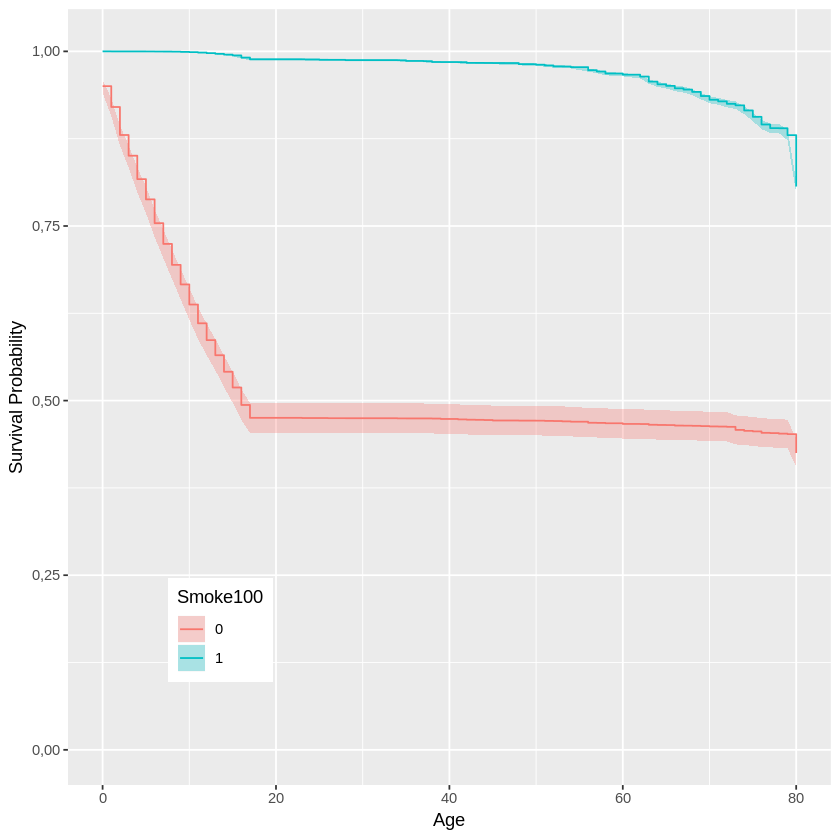

In [97]:
#Plotting survival curves for samples in the test dataset stratifying by a variable
plot(gg_rfsrc(rfsrc_NHANES_test, by = "Smoke100")) +
labs(y = "Survival Probability", x = "Age",
color = "Smoke100", fill = "Smoke100") +
theme(legend.position = c(0.2, 0.2)) +
coord_cartesian(y = c(0, 1.01))